### 📘 Descrição do Projeto
##### Este projeto tem como objetivo a construção de uma estratégia quantitativa baseada em dados do mercado financeiro brasileiro, utilizando métodos analíticos e estatísticos. As etapas previstas incluem:

1. Web scraping para identificação de ativos com boa liquidez listados no índice Ibovespa.

2. Coleta histórica das cotações diárias dos ativos selecionados.

3. Análise comparativa entre risco e retorno, com a construção de um indicador quantitativo de desempenho.

4. Seleção dos melhores ativos com base no indicador desenvolvido.

5. Aplicação da metodologia de análise com janela deslizante (Walk-Forward Analysis - WFA) para testar a performance em períodos subsequentes.

6. Desenvolvimento de uma função para coleta de proventos (dividendos e juros sobre capital próprio), com reinvestimento proporcional ao longo do tempo.

7. Rebalanceamento da carteira com base em regras definidas e análise de séries temporais para ajuste da estratégia.

8. Avaliação das estatísticas de performance da carteira (Sharpe Ratio, Drawdown, Volatilidade, etc.), comparativos com benchmarks e plotagem gráficas.

9. Geração de relatório analítico e comparativo em formato PDF, incluindo benchmark contra índices de mercado.


#### Importando bibliotecas

In [1]:
# Bibliotecas para web scraping
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.microsoft import EdgeChromiumDriverManager

# Bibliotecas para dados e manipulação de dados
import pandas as pd
import numpy as np
import math
import yfinance as yf
import datetime as dt

# Bibliotecas para análises estatísticas
import quantstats as qs

# Bibliotecas gráficas
import mplcyberpunk
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

# Bibliotecas para criação de PDfs
from fpdf import FPDF
import random

# Outras bibliotecas auxiliares
import requests
import warnings
import os
from scipy.optimize import minimize

warnings.filterwarnings("ignore")
plt.style.use("cyberpunk")

c:\Users\William Brandão\AppData\Local\Programs\Python\Python310\lib\site-packages\fpdf\__init__.py:40: UserWarning: You have both PyFPDF & fpdf2 installed. Both packages cannot be installed at the same time as they share the same module namespace. To only keep fpdf2, run: pip uninstall --yes pypdf && pip install --upgrade fpdf2
  warnings.warn(


### 1. Web Scraping
#### As informações virão do site FUNDAMENTUS.COM e do site do BCB Banco Central

Pegaremos a coluna com o ticker das empresas

In [2]:
driver = webdriver.Edge(service=Service(EdgeChromiumDriverManager().install()))
driver.get('https://www.fundamentus.com.br/resultado.php')  # Ações
local_tabela = '/html/body/div[1]/div[2]/table'
tabela = driver.find_element('xpath', local_tabela)
html_tabela = tabela.get_attribute('outerHTML')
tabela = pd.read_html(str(html_tabela), thousands='.', decimal=',')[0]

In [3]:
# Filtro para empresas que tenham liquidez acima de 10 milhões nos ultimos 2 meses
lista_acoes = (tabela[tabela['Liq.2meses'] > 10000000]['Papel'] + '.SA').to_list()
print('A quantidade de empresas é', len(lista_acoes))

A quantidade de empresas é 139


Extraindo dados do CDI diretamente do Banco Central

In [4]:
def buscar_cdi_diario(data_inicial, data_final):
    # Série do CDI diário no SGS
    codigo_serie = 12
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_serie}/dados'
    
    # Parâmetros da requisição
    params = {
        'formato': 'json',
        'dataInicial': data_inicial,
        'dataFinal': data_final
    }

    # Fazendo a requisição
    response = requests.get(url, params=params)
    dados = response.json()

    # Convertendo para DataFrame
    df = pd.DataFrame(dados)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df['valor'] = pd.to_numeric(df['valor'].str.replace(',', '.'))
    return df

### 2. Coleta de cotações históricas
#### Informações do yahoo finance

In [5]:
data_inicial = '2017-07-01'
data_final = '2025-12-31'

# Dados de fechamento diário
# Tratando dados de cotações faltantes com zero 
ativos = yf.download(lista_acoes, start=data_inicial, end=data_final, interval='1d')['Close'].fillna(0)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  139 of 139 completed

1 Failed download:
['BRKM5.SA']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


In [6]:
ativos

Ticker,ABCB4.SA,ABEV3.SA,ALOS3.SA,ALPA4.SA,ALUP11.SA,AMBP3.SA,AMER3.SA,ANIM3.SA,ASAI3.SA,AURA33.SA,...,USIM5.SA,VALE3.SA,VAMO3.SA,VBBR3.SA,VIVA3.SA,VIVT3.SA,VLID3.SA,VULC3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-03,9.536493,14.182061,0.000000,10.342458,11.880353,0.000000,1126.547974,4.631812,0.00,0.000000,...,3.682451,16.597776,0.00,0.000000,0.000000,8.618697,10.754834,3.901024,6.122892,11.995716
2017-07-04,9.406182,14.151026,0.000000,10.349899,11.940421,0.000000,1125.587524,4.745546,0.00,0.000000,...,3.658947,16.580984,0.00,0.000000,0.000000,8.618697,11.122764,3.838773,6.146768,12.216949
2017-07-05,9.370640,14.135509,0.000000,10.230849,12.013839,0.000000,1109.260742,4.756918,0.00,0.000000,...,3.713792,16.194727,0.00,0.000000,0.000000,8.762342,11.342103,3.866441,6.177466,12.290692
2017-07-06,9.388412,13.794148,0.000000,10.230849,12.113955,0.000000,1104.458740,4.717113,0.00,0.000000,...,3.792141,16.189129,0.00,0.000000,0.000000,8.479839,11.320877,3.811106,6.044436,12.069461
2017-07-07,9.210714,13.980348,0.000000,10.387100,11.887027,0.000000,1084.290405,4.415717,0.00,0.000000,...,3.799976,16.172337,0.00,0.000000,0.000000,8.362530,11.653428,3.956357,6.126302,12.290692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,21.200001,14.300000,21.120001,7.350000,30.150000,138.009995,5.770000,3.080000,9.21,37.000000,...,5.750000,54.040001,5.19,18.940001,21.440001,27.230000,24.280001,16.420000,50.320000,14.029344
2025-04-29,21.500000,14.510000,21.170000,7.380000,30.360001,122.010002,5.930000,3.070000,9.10,37.400002,...,5.730000,53.840000,5.16,18.740000,21.540001,27.430000,24.240000,16.750000,50.470001,14.300000
2025-04-30,21.700001,14.570000,21.260000,7.400000,30.820000,122.000000,5.660000,3.190000,9.19,39.180000,...,5.530000,52.860001,4.92,18.799999,22.110001,27.790001,24.750000,16.799999,44.639999,14.290000


### 3. Walk-Forward Analysis - (WFA)
#### Separando os periodos in sample e out of sample

In [7]:
# In sample
ano_1 = ativos['2015-01-01':'2017-12-31']
ano_2 = ativos['2016-01-01':'2018-12-31']
ano_3 = ativos['2017-01-01':'2019-12-31']
ano_4 = ativos['2018-01-01':'2020-12-31']
ano_5 = ativos['2019-01-01':'2021-12-31']
ano_6 = ativos['2020-01-01':'2022-12-31']
ano_7 = ativos['2021-01-01':'2023-12-31']
ano_8 = ativos['2022-01-01':'2024-12-31']

# Out of sample (em formato de data para as próximas etapas)
out_1 = ativos['2018-01-01':'2018-12-31'].index
out_2 = ativos['2019-01-01':'2019-12-31'].index
out_3 = ativos['2020-01-01':'2020-12-31'].index
out_4 = ativos['2021-01-01':'2021-12-31'].index
out_5 = ativos['2022-01-01':'2022-12-31'].index
out_6 = ativos['2023-01-01':'2023-12-31'].index
out_7 = ativos['2024-01-01':'2024-12-31'].index
out_8 = ativos['2025-01-01':'2025-12-31'].index

### 4. Criação do indicador baseado em risco retorno
#### Usando o cálculo estatístico de SHARPE de cada ativo para cada ano

In [8]:
def calcular_acoes_por_ano(ano, top_n=10):
    """
    Calcula os ativos a serem usados em um determinado ano com base no índice Sharpe.

    Parâmetros:
        ano (pd.DataFrame): DataFrame contendo os dados de ativos para o ano.
        top_n (int): Número de ativos com maior índice Sharpe a serem selecionados.

    Retorna:
        pd.Index: Índices dos ativos selecionados.
    """
    def calcular_sharpe(data):
        variacao = data.pct_change().fillna(0)
        ret_total = variacao.sum()
        x = len(variacao)
        x1 = math.sqrt(x)
        desvio = variacao.std() * x1
        sharpe = ret_total / desvio
        return sharpe[sharpe > 0]

    sharpe_scores = calcular_sharpe(ano)
    return sharpe_scores.sort_values(ascending=False).head(top_n).index

# Para cada ano
acoes_a_usar_ano_1 = calcular_acoes_por_ano(ano_1)
acoes_a_usar_ano_2 = calcular_acoes_por_ano(ano_2)
acoes_a_usar_ano_3 = calcular_acoes_por_ano(ano_3)
acoes_a_usar_ano_4 = calcular_acoes_por_ano(ano_4)
acoes_a_usar_ano_5 = calcular_acoes_por_ano(ano_5)
acoes_a_usar_ano_6 = calcular_acoes_por_ano(ano_6)
acoes_a_usar_ano_7 = calcular_acoes_por_ano(ano_7)
acoes_a_usar_ano_8 = calcular_acoes_por_ano(ano_8)

### 5. Seleção dos 10 melhores ativos de cada periodo segundo o indicador
#### Em formato de lista para input no yfinance

In [9]:
print(acoes_a_usar_ano_1)
print(acoes_a_usar_ano_2)
print(acoes_a_usar_ano_3)
print(acoes_a_usar_ano_4)
print(acoes_a_usar_ano_5)
print(acoes_a_usar_ano_6)
print(acoes_a_usar_ano_7)
print(acoes_a_usar_ano_8)

Index(['PRIO3.SA', 'GFSA3.SA', 'YDUQ3.SA', 'UNIP6.SA', 'ANIM3.SA', 'RENT3.SA',
       'CVCB3.SA', 'GUAR3.SA', 'MGLU3.SA', 'BHIA3.SA'],
      dtype='object', name='Ticker')
Index(['UNIP6.SA', 'MGLU3.SA', 'TEND3.SA', 'AMER3.SA', 'SLCE3.SA', 'PSSA3.SA',
       'BPAC11.SA', 'RENT3.SA', 'PRIO3.SA', 'ENGI11.SA'],
      dtype='object', name='Ticker')
Index(['MGLU3.SA', 'BPAC11.SA', 'CPLE3.SA', 'TEND3.SA', 'PRIO3.SA', 'UNIP6.SA',
       'ENEV3.SA', 'EZTC3.SA', 'DIRR3.SA', 'ENGI11.SA'],
      dtype='object', name='Ticker')
Index(['MGLU3.SA', 'ENEV3.SA', 'CPLE3.SA', 'WEGE3.SA', 'BPAC11.SA', 'PRIO3.SA',
       'CPLE6.SA', 'TAEE11.SA', 'UNIP6.SA', 'JHSF3.SA'],
      dtype='object', name='Ticker')
Index(['PRIO3.SA', 'KEPL3.SA', 'WEGE3.SA', 'MRFG3.SA', 'ENEV3.SA', 'UNIP6.SA',
       'TAEE11.SA', 'JBSS3.SA', 'TOTS3.SA', 'CPLE6.SA'],
      dtype='object', name='Ticker')
Index(['UNIP6.SA', 'PRIO3.SA', 'KEPL3.SA', 'BRAP4.SA', 'SLCE3.SA', 'WEGE3.SA',
       'VALE3.SA', 'TAEE11.SA', 'GOAU4.SA', 'GGBR4.SA'

### Empresas selecionadas em 2018
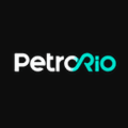
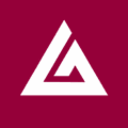
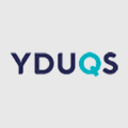
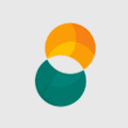
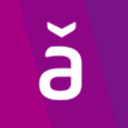
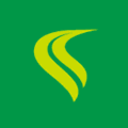
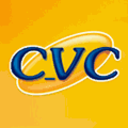
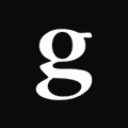
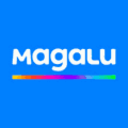

### Empresas selecionadas em 2019
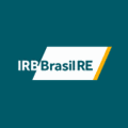
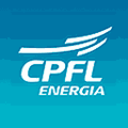
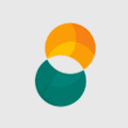
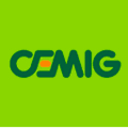
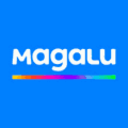
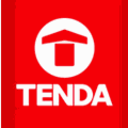
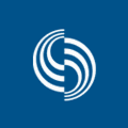
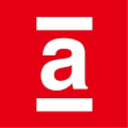
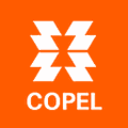
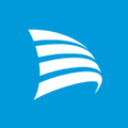

### Empresas selecionadas em 2020
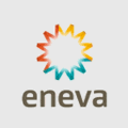
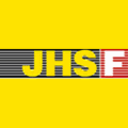
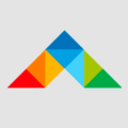
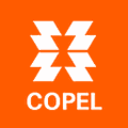
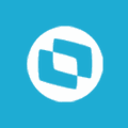
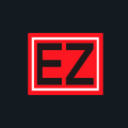
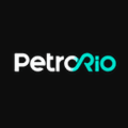
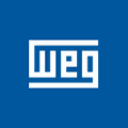
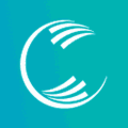

### Empresas selecionadas em 2021
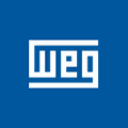
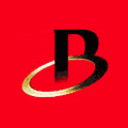
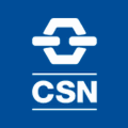
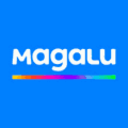
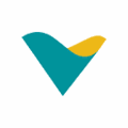
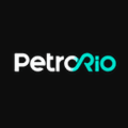
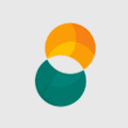
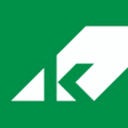

### Empresas selecionadas em 2022
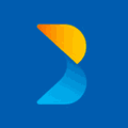
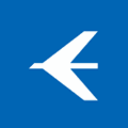
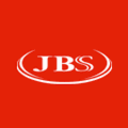
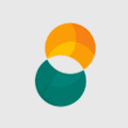
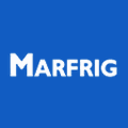
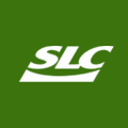
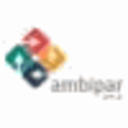
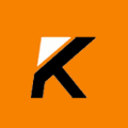
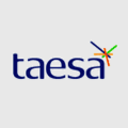
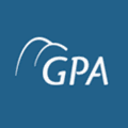

### 6. Coleta de proventos e reinvestimentos
#### Nesta etapa do projeto, iremos coletar todos pagamentos de proventos de cada ativo durante o periodo e simular reinvestimentos e um acumulo de capital e de proventos

In [10]:
data_inicial = out_1[0]
data_final = out_1[-1]

import yfinance
# Coleta de proventos
def dividendo_por_acao(lista, data):
    dividendos_att = lista[(lista.index.month == data.month) & (lista.index.year == data.year) & (lista.index.day == data.day)]
    dividendos_att = dividendos_att.sum()
    return dividendos_att

# Simulando um acumulo de capital com um aporte inicial, reinvestindo os proventos e acumulando as sobras
def calcula_investimento(ticker, inicio=data_inicial, termino=data_final, aporte_mensal=0.00, resto_anterior=0.00):
    lista_dividendos = yf.Ticker(ticker).dividends
    hist = yfinance.download(ticker, start=inicio, end=termino)
    hist = hist.xs((ticker), level='Ticker', axis=1)
    hist = hist.dropna()
    hist['valor_investido'] = 0.00
    hist['aporte_mensal'] = aporte_mensal
    hist['aporte_total'] = 0.00
    hist['total_acoes'] = 0.00
    hist['resto'] = 0.00
    hist['dividendos'] = 0.00
    total_linhas = hist.shape[0]

    for i in range(0, total_linhas):
        linha = hist.iloc[i,:]
        data = hist.index[i]
        valor_fechamento = linha['Close']
        if i > 0:
            linha_anterior = hist.iloc[i-1,:]
            acoes_anterior = linha_anterior['total_acoes']
            resto_anterior = linha_anterior['resto']
        else:
            acoes_anterior = 0.00
            resto_anterior = resto_anterior
        
        dividendo = dividendo_por_acao(lista_dividendos, data)
        total_dividendos = dividendo * acoes_anterior
        aporte_total = aporte_mensal + resto_anterior + total_dividendos
        novas_acoes = int(aporte_total / valor_fechamento)
        total_acoes = acoes_anterior + novas_acoes
        valor_investido = total_acoes * valor_fechamento
        resto = aporte_total - novas_acoes * valor_fechamento
        # Substituir valores
        hist.at[data, 'valor_investido'] = valor_investido
        hist.at[data, 'aporte_total'] = aporte_total
        hist.at[data, 'total_acoes'] = total_acoes
        hist.at[data, 'resto'] = resto
        hist.at[data, 'dividendos'] = total_dividendos

    return hist

### 7. Rebalanceamento da carteira
O rebalanceamento da carteira é uma prática essencial, uma vez que, ao longo do tempo, os ativos tendem a acumular valores distintos entre si, o que pode resultar em riscos financeiros desproporcionais. <br>
Ajustar os pesos dos ativos contribui para a mitigação desses riscos, pode potencializar os retornos e proporciona maior segurança ao portfólio.

In [11]:
def calcula_investimento_por_ano(lista_acoes_por_ano, periodos_out, capital_inicial):
    """
    Calcula o investimento acumulado ano a ano, preservando o capital acumulado do ano anterior
    e utilizando a lista de empresas específica para cada ano.

    Parâmetros:
        lista_acoes_por_ano (list): Lista contendo as listas de empresas para cada ano.
        periodos_out (list): Lista contendo os períodos (datas) para cada ano.
        capital_inicial (float): Capital inicial para o primeiro ano.

    Retorna:
        dict: Um dicionário com os DataFrames de cada ano e o capital acumulado final.
    """
    resultados = {}
    capital = capital_inicial

    for ano_idx, (acoes_ano, periodo) in enumerate(zip(lista_acoes_por_ano, periodos_out), start=1):
        df_ano = pd.DataFrame()

        for acao in acoes_ano:
            try:
                # Dividindo o capital igualmente entre as empresas do ano
                df_ano[acao] = calcula_investimento(
                    acao,
                    inicio=periodo[0],
                    termino=periodo[-1],
                    aporte_mensal=0,
                    resto_anterior=(capital / len(acoes_ano))
                )['valor_investido']
            except Exception as e:
                print(f"Erro ao processar {acao} no ano {ano_idx}: {e}")

        # Total acumulado do período
        capital = df_ano.sum(axis=1).iloc[-1]
        resultados[f"ano_{ano_idx}"] = {"df": df_ano, "acumulado": capital}

    return resultados

# Lista de anos e ações a serem usadas
lista_acoes_por_ano = [
    acoes_a_usar_ano_1,
    acoes_a_usar_ano_2,
    acoes_a_usar_ano_3,
    acoes_a_usar_ano_4,
    acoes_a_usar_ano_5,
    acoes_a_usar_ano_6,
    acoes_a_usar_ano_7,
    acoes_a_usar_ano_8,
]

periodos_out = [out_1, out_2, out_3, out_4, out_5, out_6, out_7, out_8]
capital_inicial = 100000

resultados = calcula_investimento_por_ano(lista_acoes_por_ano, periodos_out, capital_inicial)

# Exibindo os resultados
for ano, dados in resultados.items():
    print(f"{ano}: Capital acumulado = {round(dados['acumulado'], 2)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

ano_1: Capital acumulado = 124795.68
ano_2: Capital acumulado = 236254.8
ano_3: Capital acumulado = 309472.08
ano_4: Capital acumulado = 366406.3
ano_5: Capital acumulado = 450176.99
ano_6: Capital acumulado = 500198.55
ano_7: Capital acumulado = 610848.68
ano_8: Capital acumulado = 722812.21


### 7. Avaliação análitca e comparativa do modelo como um todo
#### Plotagem gráfica

In [25]:
acumulados_por_ano = pd.DataFrame({
    'Ano': ['2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025'],
    'Acumulado': [
        resultados['ano_1']['acumulado'],
        resultados['ano_2']['acumulado'],
        resultados['ano_3']['acumulado'],
        resultados['ano_4']['acumulado'],
        resultados['ano_5']['acumulado'],
        resultados['ano_6']['acumulado'],
        resultados['ano_7']['acumulado'],
        resultados['ano_8']['acumulado']
    ]
})

# Exibir o DataFrame
display(acumulados_por_ano)

,Ano,Acumulado
0,2018,124795.683060
1,2019,236254.797575
2,2020,309472.084258
3,2021,366406.303405
4,2022,450176.994245
5,2023,500198.549704
6,2024,610848.675530
7,2025,722812.211776


In [26]:
# Juntando os dataframes de cada ano
# e somando os valores de cada ação
capital_acumulado = pd.concat(
    [resultados['ano_1']['df'].sum(axis=1), resultados['ano_2']['df'].sum(axis=1), resultados['ano_3']['df'].sum(axis=1),
     resultados['ano_4']['df'].sum(axis=1), resultados['ano_5']['df'].sum(axis=1), resultados['ano_6']['df'].sum(axis=1),
     resultados['ano_7']['df'].sum(axis=1), resultados['ano_8']['df'].sum(axis=1)], axis=0
)

# Ordenar por data
# todos_resultados.sort_index(inplace=True)

########################################################### Baixando dados do indice BOVA11
bova_11 = yf.download('BOVA11.SA', out_1[0], out_8[-1])['Close']
bova_11 = bova_11.rename(columns={'BOVA11.SA':'ibovespa'})

# Acumulando o capital financeiro no ativo BOVA11, etf que replica o indice ibovespa
bova_11_acumulado = round(100000 / bova_11.iloc[0] * bova_11, 2)
# bova_11_acumulado.plot(figsize=(20,7),linewidth=0.5)

############################################################ Baixando dados do indice SMAL11
smal11 = yf.download('SMAL11.SA', out_1[0], out_8[-1])['Close']
smal11 = smal11.rename(columns={'SMAL11.SA':'small caps'})

# Acumulando o capital financeiro no ativo SMAL11, etf que replica o indice de small caps (pequenas empresas da b3)
smal11_acumulado = round(100000 / smal11.iloc[0] * smal11, 2)
# smal11_acumulado.plot(figsize=(20,7),linewidth=0.5)

# Baixando dados do DÓLAR
dolar = yf.download('USDBRL=X', out_1[0], out_8[-1])['Close']

############################################################# Acumulando o capital financeiro em DÓLAR
dolar_acumulado = round(100000 / dolar.iloc[0] * dolar, 2)
dolar_acumulado = dolar_acumulado.rename(columns={'USDBRL=X':'dolar'})
# dolar_acumulado.plot(figsize=(20,7),linewidth=0.5)

# Baixando dados do S&P500
sp500 = yf.download('IVVB11.SA', out_1[0], out_8[-1])['Close']

############################################################### Acumulando o capital financeiro em DÓLAR
sp500_acumulado = round(100000 / sp500.iloc[0] * sp500, 2)
sp500_acumulado = sp500_acumulado.rename(columns={'IVVB11.SA':'sp500'})
# sp500_acumulado.plot(figsize=(20,7),linewidth=0.5)

# Trazendo dados do índice de FUNDOS IMOBILIÁRIOS
ifix = pd.read_csv(r'C:\Users\William Brandão\Desktop\Códigos .py\ifix.csv').set_index('data')
ifix = ifix.rename(columns={'valor':'ifix'})
ifix.index = pd.to_datetime(ifix.index)

################################################################ Acumulando o capital financeiro em FUNDOS IMOBILIÁRIOS
ifix_acumulado = round(100000 / ifix['ifix'].iloc[0] * ifix['ifix'], 2)
# ifix_acumulado.plot(figsize=(20,7),linewidth=0.5)

################################################################# Trazendo dados do CDI
df_cdi = buscar_cdi_diario('01/01/2018', '31/12/2025')
# Transformando a data em índice

df_cdi = df_cdi.set_index('data')
df_cdi.rename(columns={'valor':'cdi'}, inplace=True)
capital_inicial = 100000
# Calcular o valor acumulado com juros compostos
cdi = capital_inicial * ((1 + df_cdi['cdi'] / 100).cumprod())
cdi.index = pd.to_datetime(cdi.index)
# cdi.plot(figsize=(20,7),linewidth=0.5)

################################################################## Trazendo dados do índice de inflação (IPCA)
ipca = pd.read_csv(r'C:\Users\William Brandão\Desktop\Códigos .py\ipca percentual.csv').set_index('Date')
ipca = ipca.rename(columns={'Price':'ipca'})
ipca.index = pd.to_datetime(ipca.index)

# Acumulando o capital financeiro inflação (IPCA)
ipca_acumulado = round((100000 * ipca['ipca'] / 100 + 100000), 2)
# ipca_acumulado.plot(figsize=(20,7),linewidth=0.5)

# Colocando todos os dados em um único dataframe (portfoilio_e_benchmarks)
# Capital acumulado do portfólio e benchmarks
portfoilio_e_benchmarks = pd.concat([capital_acumulado, bova_11_acumulado, cdi, smal11_acumulado, ifix_acumulado, dolar_acumulado, ipca_acumulado, sp500_acumulado], axis=1).ffill()
portfoilio_e_benchmarks = portfoilio_e_benchmarks.rename(columns={0: 'portfolio'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [27]:
# Gráfico 1: Acumulado Total
fig_acumulado = px.line(
    portfoilio_e_benchmarks,
    x=portfoilio_e_benchmarks.index,
    y=portfoilio_e_benchmarks.columns,
    title="📈 Acumulado Total - Portfólio e Benchmarks",
    labels={"value": "Valor Acumulado", "variable": "Indicador"},
    template="plotly_dark"
)
fig_acumulado.update_layout(
    xaxis_title="Data",
    yaxis_title="Valor Acumulado",
    legend_title="Indicador",
    hovermode="x unified",
    updatemenus=[dict(
        buttons=[
            dict(label=col, method="update", args=[{"visible": [col == c for c in portfoilio_e_benchmarks.columns]}])
            for col in portfoilio_e_benchmarks.columns
        ],
        direction="down",
        showactive=True,
    )]
)
fig_acumulado.show()

# Gráfico 2: Retorno Diário
retorno_diario = portfoilio_e_benchmarks.pct_change().dropna() * 100  # Retorno diário em porcentagem
fig_diario = px.line(
    retorno_diario,
    x=retorno_diario.index,
    y=retorno_diario.columns,
    title="📉 Retorno Diário - Portfólio e Benchmarks",
    labels={"value": "Retorno Diário (%)", "variable": "Indicador"},
    template="plotly_dark"
)
fig_diario.update_layout(
    xaxis_title="Data",
    yaxis_title="Retorno Diário (%)",
    legend_title="Indicador",
    hovermode="x unified",
    updatemenus=[dict(
        buttons=[
            dict(label=col, method="update", args=[{"visible": [col == c for c in retorno_diario.columns]}])
            for col in retorno_diario.columns
        ],
        direction="down",
        showactive=True,
    )]
)
fig_diario.show()

AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
# 1. Retorno Acumulado
fig1 = px.line(
    portfoilio_e_benchmarks,
    x=portfoilio_e_benchmarks.index,
    y=portfoilio_e_benchmarks.columns,
    title="📈 Retorno Acumulado - Portfólio e Benchmarks",
    labels={"value": "Valor Acumulado", "variable": "Indicador"},
    template="plotly_dark"
)
fig1.update_layout(
    xaxis_title="Data",
    yaxis_title="Valor Acumulado",
    legend_title="Indicador",
    hovermode="x unified"
)
fig1.show()

# 2. Percentual Acumulado por Ano (em barras)
fig2 = px.bar(
    percentual_acumulado_long,
    x="Ano",
    y="Percentual Acumulado (%)",
    color="Indicador",
    barmode="group",
    title="📊 Percentual Acumulado por Ano e Benchmark",
    template="plotly_dark"
)
fig2.update_layout(
    xaxis_title="Ano",
    yaxis_title="Percentual Acumulado (%)",
    yaxis=dict(ticksuffix="%"),
    legend_title="Indicador",
    hovermode="x unified"
)
fig2.show()

# 3. Drawdowns
fig3 = go.Figure()
for indicador in portfoilio_e_benchmarks.columns:
    serie = portfoilio_e_benchmarks[indicador]
    pico = serie.cummax()
    drawdown = (serie - pico) / pico
    fig3.add_trace(go.Scatter(
        x=serie.index,
        y=drawdown * 100,
        mode='lines',
        name=indicador,
        hovertemplate='%{y:.2f}%<br>%{x|%d/%m/%Y}<extra>' + indicador + '</extra>'
    ))
fig3.update_layout(
    title="📉 Drawdowns Máximos (% Percentual) dos Indicadores",
    xaxis_title="Data",
    yaxis_title="Drawdown (%)",
    template="plotly_dark",
    hovermode="x unified",
    legend_title="Indicadores",
    yaxis=dict(ticksuffix="%", zeroline=False)
)
fig3.show()

# 4. Drawdowns Máximo (em barras)
drawdown_maximos = {}
for indicador in portfoilio_e_benchmarks.columns:
    serie = portfoilio_e_benchmarks[indicador]
    pico = serie.cummax()
    drawdown = (serie - pico) / pico
    drawdown_maximos[indicador] = drawdown.min() * 100
drawdown_bar_df = pd.DataFrame({
    "Indicador": list(drawdown_maximos.keys()),
    "Drawdown Máximo (%)": list(drawdown_maximos.values())
}).sort_values(by="Drawdown Máximo (%)")
fig4 = px.bar(
    drawdown_bar_df,
    x="Indicador",
    y="Drawdown Máximo (%)",
    title="📊 Drawdown Máximo por Indicador (%)",
    text="Drawdown Máximo (%)",
    color="Indicador",
    template="plotly_dark"
)
fig4.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig4.update_layout(
    yaxis_title="Drawdown Máximo (%)",
    xaxis_title="Indicador",
    yaxis=dict(ticksuffix="%"),
    showlegend=False
)
fig4.show()

# 5. Risco x Retorno (Dispersão)
dados_rr = []
for indicador in portfoilio_e_benchmarks.columns:
    serie = portfoilio_e_benchmarks[indicador]
    retornos_diarios = serie.pct_change().dropna()
    retorno_total = (serie.iloc[-1] / serie.iloc[0]) - 1
    volatilidade = retornos_diarios.std() * (252**0.5)  # volatilidade anualizada
    dados_rr.append({
        "Indicador": indicador,
        "Retorno (%)": retorno_total * 100,
        "Risco (Volatilidade %)": volatilidade * 100
    })
df_rr = pd.DataFrame(dados_rr)
fig5 = px.scatter(
    df_rr,
    x="Risco (Volatilidade %)",
    y="Retorno (%)",
    text="Indicador",
    title="📈 Comparativo Risco x Retorno (em %)",
    template="plotly_dark"
)
fig5.update_traces(marker=dict(size=12, color='royalblue', line=dict(width=2, color='DarkSlateGrey')))
fig5.update_layout(
    xaxis_title="Risco (Volatilidade Anual %)",
    yaxis_title="Retorno Acumulado (%)",
    hovermode="closest"
)
fig5.show()

# 6. Índice de Sharpe (Sem Ativo Livre de Risco)
taxa_livre_risco = 0.0  # Ignorar ativo livre de risco
dados_sharpe = []
for indicador in indicadores_sem_cdi:
    serie = portfoilio_e_benchmarks[indicador]
    retornos_diarios = serie.pct_change().dropna()
    retorno_total = (serie.iloc[-1] / serie.iloc[0]) - 1
    retorno_anual = ((1 + retorno_total) ** (252 / len(retornos_diarios))) - 1
    volatilidade = retornos_diarios.std() * (252 ** 0.5)
    sharpe = (retorno_anual - taxa_livre_risco) / volatilidade if volatilidade != 0 else 0
    dados_sharpe.append({"Indicador": indicador, "Sharpe Ratio": sharpe})
df_sharpe = pd.DataFrame(dados_sharpe).sort_values(by="Sharpe Ratio", ascending=False)
fig6 = px.bar(
    df_sharpe,
    x="Indicador",
    y="Sharpe Ratio",
    text="Sharpe Ratio",
    title="📊 Sharpe Ratio por Indicador",
    color="Indicador",
    template="plotly_dark"
)
fig6.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig6.update_layout(
    yaxis_title="Sharpe Ratio",
    xaxis_title="Indicador",
    showlegend=False
)
fig6.show()

# 7. Taxa de Acerto
taxa_acerto = {}
for indicador in indicadores_sem_cdi:
    retornos_diarios = portfoilio_e_benchmarks[indicador].pct_change().dropna()
    acertos = (retornos_diarios > 0).sum()
    total = len(retornos_diarios)
    taxa_acerto[indicador] = (acertos / total) * 100  # Em percentual
df_taxa_acerto = pd.DataFrame(list(taxa_acerto.items()), columns=["Indicador", "Taxa de Acerto (%)"])
fig7 = px.bar(
    df_taxa_acerto,
    x="Indicador",
    y="Taxa de Acerto (%)",
    text="Taxa de Acerto (%)",
    title="📊 Taxa de Acerto por Indicador",
    color="Indicador",
    template="plotly_dark"
)
fig7.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig7.update_layout(
    yaxis_title="Taxa de Acerto (%)",
    xaxis_title="Indicador",
    yaxis=dict(ticksuffix="%"),
    showlegend=False
)
fig7.show()

# 8. Tracking Error
tracking_errors = {}
retornos_portfolio = portfoilio_e_benchmarks['portfolio'].pct_change().dropna()
for indicador in indicadores_sem_cdi:
    if indicador != 'portfolio':  # Ignorar o próprio portfólio
        retornos_benchmark = portfoilio_e_benchmarks[indicador].pct_change().dropna()
        retornos_portfolio_aligned, retornos_benchmark_aligned = retornos_portfolio.align(retornos_benchmark, join='inner')
        tracking_error = (retornos_portfolio_aligned - retornos_benchmark_aligned).std() * (252 ** 0.5)
        tracking_errors[indicador] = tracking_error * 100
df_tracking_error = pd.DataFrame(list(tracking_errors.items()), columns=["Indicador", "Tracking Error"])
fig8 = px.bar(
    df_tracking_error,
    x="Indicador",
    y="Tracking Error",
    text="Tracking Error",
    title="📊 Tracking Error Anualizado por Indicador (%)",
    color="Indicador",
    template="plotly_dark"
)
fig8.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig8.update_layout(
    yaxis_title="Tracking Error Anualizado (%)",
    xaxis_title="Indicador",
    showlegend=False
)
fig8.show()

# 9. Matriz de Correlação
correlation_matrix = round(portfoilio_e_benchmarks.corr(), 2)
fig9 = px.imshow(
    correlation_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title="📊 Matriz de Correlação Interativa",
    labels=dict(color="Correlação"),
    template="plotly_dark"
)
fig9.update_layout(
    xaxis_title="Indicador",
    yaxis_title="Indicador",
    coloraxis_colorbar=dict(title="Correlação"),
    title_font_size=20,
    width=2170, height=700
)
fig9.show()

Fronteira eficiente de Markovits

In [ ]:
import numpy as np

import plotly.graph_objects as go

# Dados do portfólio
retornos = portfoilio_e_benchmarks.pct_change().dropna()
ativos = retornos.columns

# Função para calcular o retorno esperado do portfólio
def calcular_retorno_pesos(pesos, retornos):
    return np.sum(pesos * retornos.mean()) * 252

# Função para calcular o risco (volatilidade) do portfólio
def calcular_risco_pesos(pesos, retornos):
    return np.sqrt(np.dot(pesos.T, np.dot(retornos.cov() * 252, pesos)))

# Função para otimizar o portfólio
def otimizar_portfolio(retornos, target_retorno):
    n_ativos = len(retornos.columns)
    pesos_iniciais = np.ones(n_ativos) / n_ativos
    limites = [(0, 1) for _ in range(n_ativos)]
    restricoes = [
        {'type': 'eq', 'fun': lambda pesos: np.sum(pesos) - 1},  # Soma dos pesos = 1
        {'type': 'eq', 'fun': lambda pesos: calcular_retorno_pesos(pesos, retornos) - target_retorno}  # Retorno alvo
    ]
    resultado = minimize(
        calcular_risco_pesos,
        pesos_iniciais,
        args=(retornos,),
        method='SLSQP',
        bounds=limites,
        constraints=restricoes
    )
    return resultado.x

# Gerar a fronteira eficiente
retornos_esperados = np.linspace(retornos.mean().min() * 252, retornos.mean().max() * 252, 50)
riscos = []
pesos_otimizados = []

for retorno_alvo in retornos_esperados:
    pesos = otimizar_portfolio(retornos, retorno_alvo)
    risco = calcular_risco_pesos(pesos, retornos)
    riscos.append(risco)
    pesos_otimizados.append(pesos)

# Criar o gráfico da fronteira eficiente
fig = go.Figure()

# Adicionar a fronteira eficiente
fig.add_trace(go.Scatter(
    x=riscos,
    y=retornos_esperados,
    mode='lines',
    name='Fronteira Eficiente',
    line=dict(color='blue', width=2)
))

# Adicionar os ativos individuais
for ativo in ativos:
    fig.add_trace(go.Scatter(
        x=[retornos[ativo].std() * np.sqrt(252)],
        y=[retornos[ativo].mean() * 252],
        mode='markers+text',
        name=ativo,
        text=ativo,
        textposition='top center',
        marker=dict(size=10, symbol='circle', color='red')
    ))

# Configurar layout do gráfico
fig.update_layout(
    title="Fronteira Eficiente de Markowitz",
    xaxis_title="Risco (Volatilidade Anualizada)",
    yaxis_title="Retorno Esperado Anualizado",
    template="plotly_dark",
    legend_title="Legenda",
    hovermode="closest"
)

# Exibir o gráfico
fig.show()

### Plotagens Gráficas para geração de imagens para o relatório em PDF

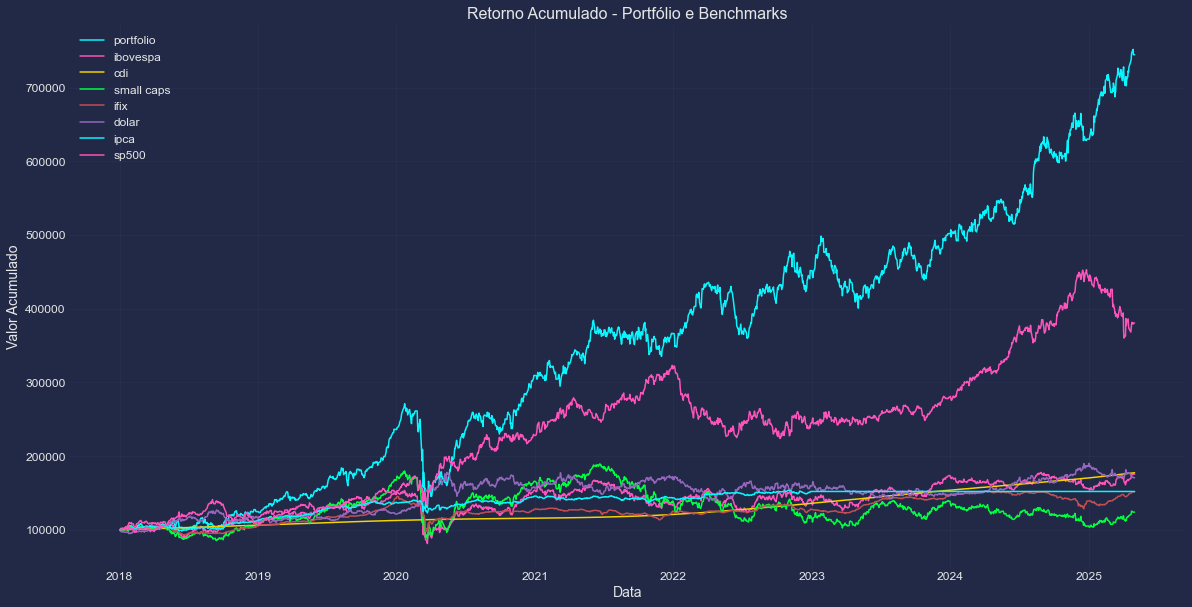

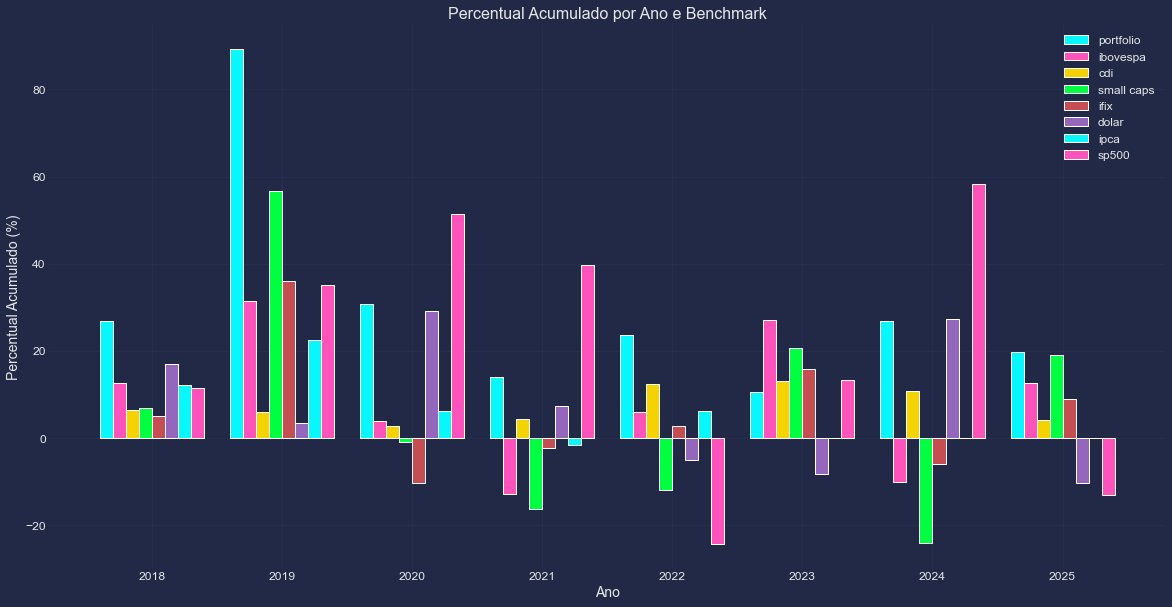

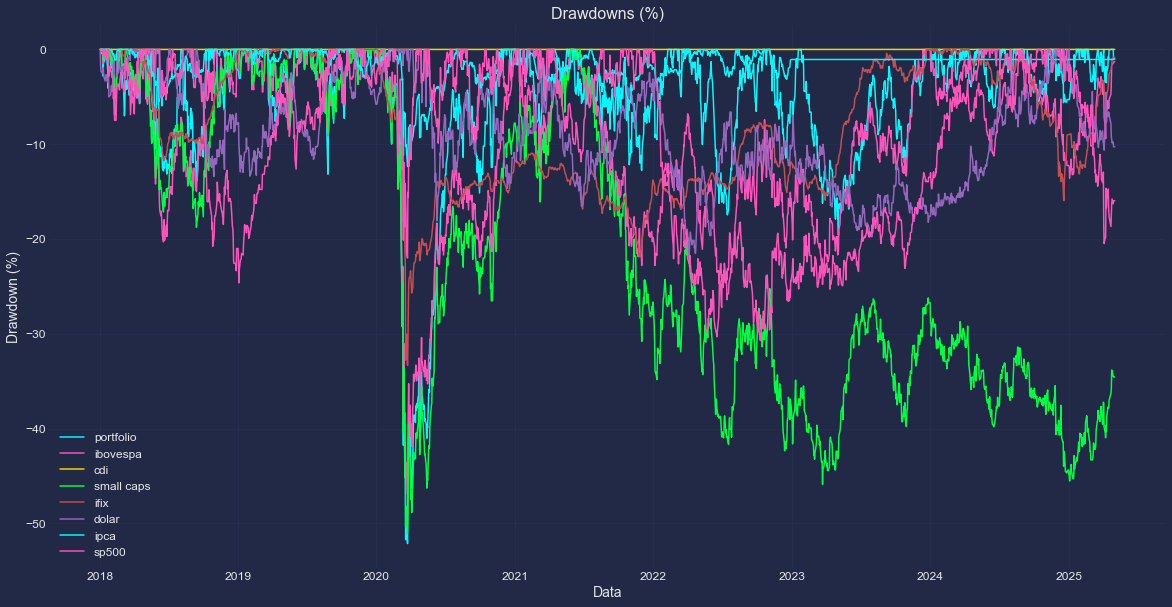

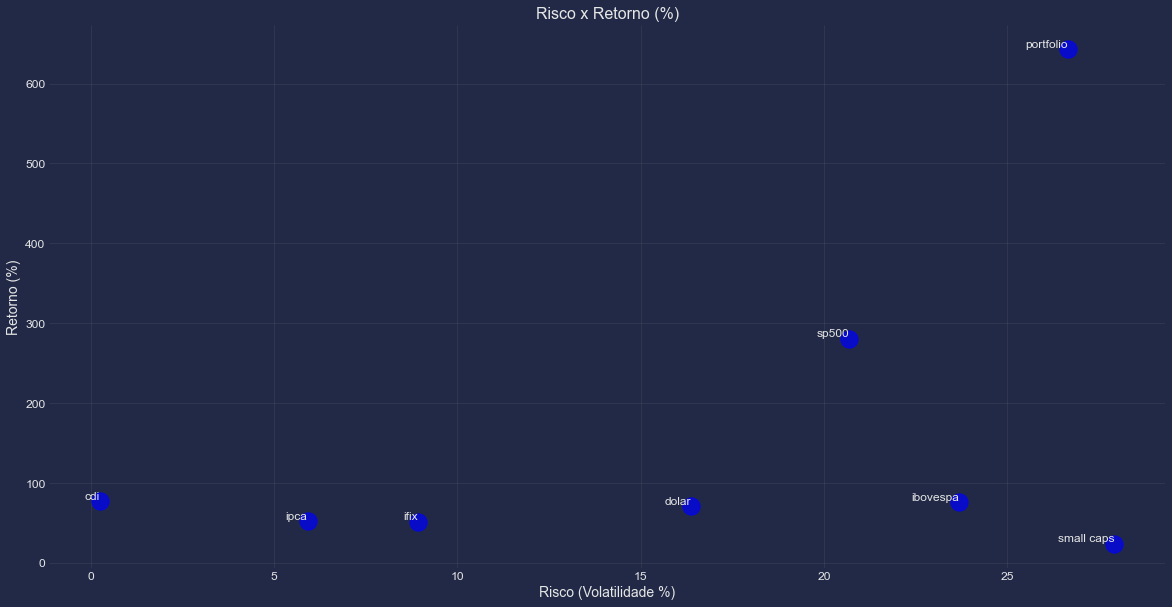

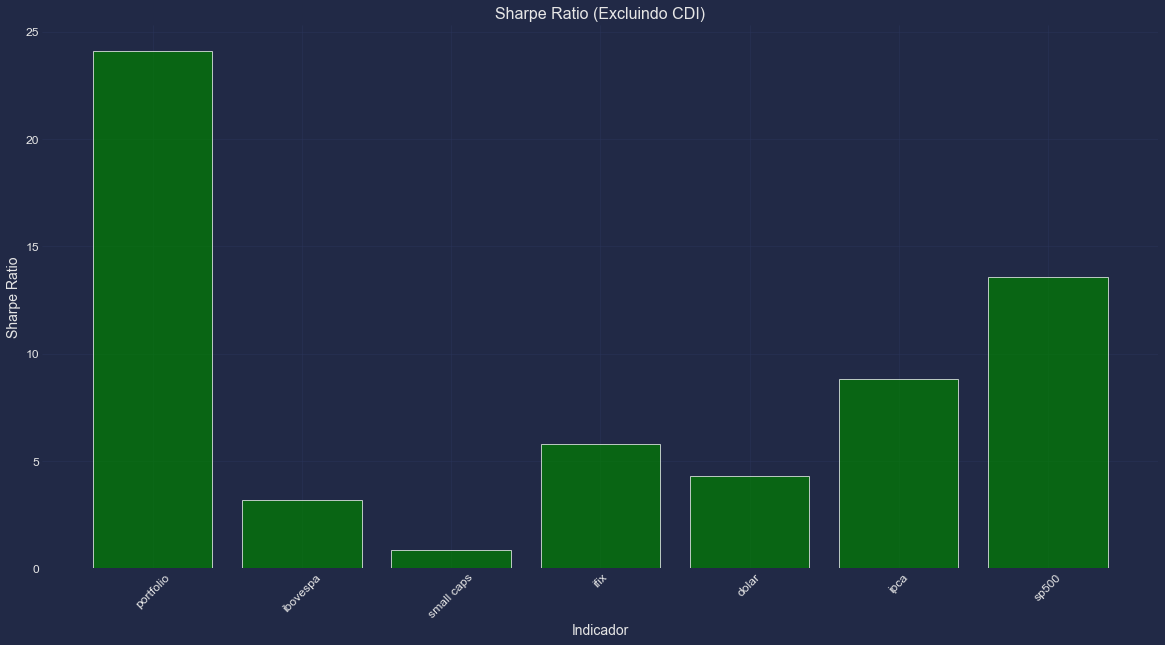

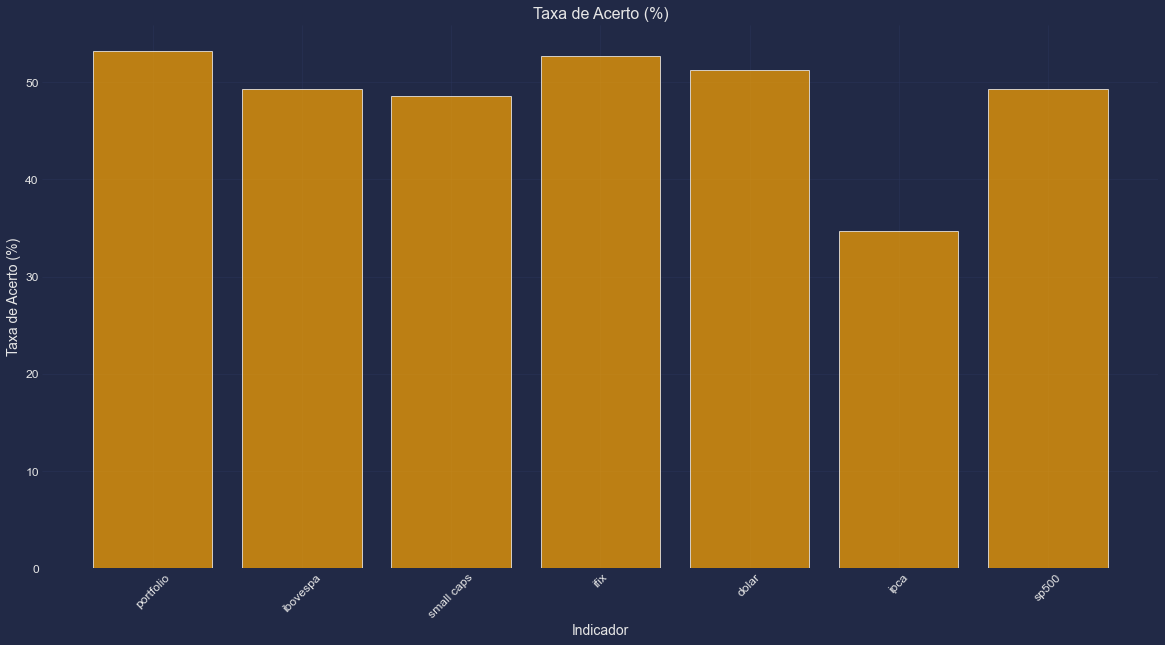

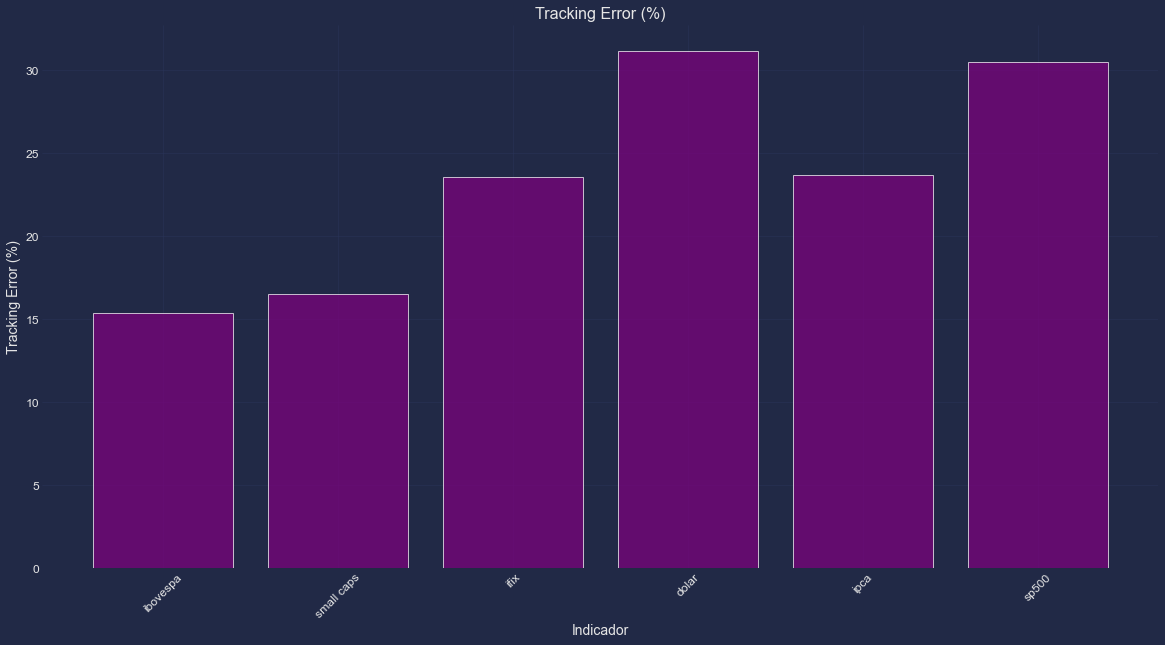

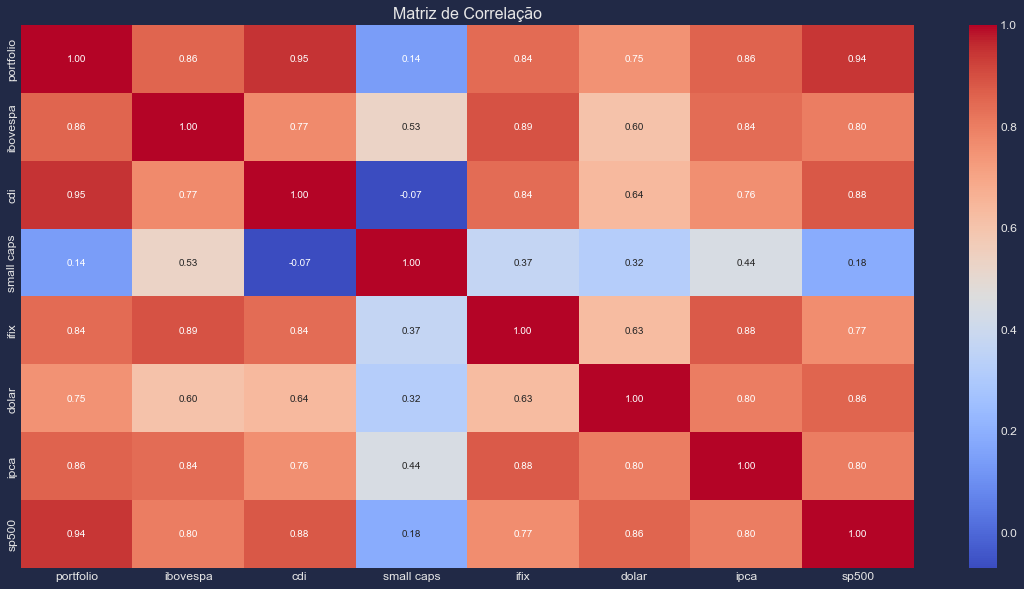

In [ ]:
# Configuração geral
plt.style.use('cyberpunk')

# 1. Gráfico de Retorno Acumulado
plt.figure(figsize=(20, 10))
for indicador in portfoilio_e_benchmarks.columns:
    plt.plot(portfoilio_e_benchmarks[indicador], label=indicador)
plt.title('Retorno Acumulado - Portfólio e Benchmarks', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Valor Acumulado', fontsize=14)
plt.legend(fontsize=12)
# mplcyberpunk.add_glow_effects()
# plt.savefig('Retorno_Acumulado.png', dpi=300)
# plt.close()

# 2. Gráfico de Percentual Acumulado por Ano (em barras)
x = np.arange(len(percentual_acumulado['Ano']))
largura = 0.1
fig, ax = plt.subplots(figsize=(20, 10))
for i, indicador in enumerate(percentual_acumulado.columns[1:]):
    ax.bar(x + i * largura, percentual_acumulado[indicador], largura, label=indicador)
ax.set_xticks(x + largura * (len(percentual_acumulado.columns[1:]) - 1) / 2)
ax.set_xticklabels(percentual_acumulado['Ano'])
ax.set_xlabel('Ano', fontsize=14)
ax.set_ylabel('Percentual Acumulado (%)', fontsize=14)
ax.set_title('Percentual Acumulado por Ano e Benchmark', fontsize=16)
ax.legend(fontsize=12)
mplcyberpunk.add_glow_effects()
# plt.savefig('Percentual_Acumulado.png', dpi=300)
# plt.close()

# 3. Gráfico de Drawdowns
plt.figure(figsize=(20, 10))
for indicador in portfoilio_e_benchmarks.columns:
    serie = portfoilio_e_benchmarks[indicador]
    pico = serie.cummax()
    drawdown = (serie - pico) / pico
    plt.plot(drawdown * 100, label=indicador)
plt.title('Drawdowns (%)', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Drawdown (%)', fontsize=14)
plt.legend(fontsize=12)
# mplcyberpunk.add_glow_effects()
# plt.savefig('Drawdowns.png', dpi=300)
# plt.close()

# 4. Gráfico de Risco x Retorno
plt.figure(figsize=(20, 10))
plt.scatter(risco, retorno, s=300, c='blue', alpha=0.7)
for i, nome in enumerate(nomes):
    plt.text(risco[i], retorno[i], nome, fontsize=12, ha='right', va='bottom')
plt.title('Risco x Retorno (%)', fontsize=16)
plt.xlabel('Risco (Volatilidade %)', fontsize=14)
plt.ylabel('Retorno (%)', fontsize=14)
plt.grid(alpha=0.3, color='gray')
mplcyberpunk.add_glow_effects()
# plt.savefig('Risco_x_Retorno.png', dpi=300)
# plt.close()

# 5. Gráfico de Sharpe Ratio
plt.figure(figsize=(20, 10))
plt.bar(indicadores_sem_cdi, sharpe_ratios_sem_cdi, color='green', alpha=0.7)
plt.title('Sharpe Ratio (Excluindo CDI)', fontsize=16)
plt.xlabel('Indicador', fontsize=14)
plt.ylabel('Sharpe Ratio', fontsize=14)
plt.xticks(rotation=45)
mplcyberpunk.add_glow_effects()
# plt.savefig('Sharpe_Ratio.png', dpi=300)
# plt.close()

# 6. Gráfico de Taxa de Acerto
plt.figure(figsize=(20, 10))
plt.bar(taxa_acerto.keys(), taxa_acerto.values(), color='orange', alpha=0.7)
plt.title('Taxa de Acerto (%)', fontsize=16)
plt.xlabel('Indicador', fontsize=14)
plt.ylabel('Taxa de Acerto (%)', fontsize=14)
plt.xticks(rotation=45)
mplcyberpunk.add_glow_effects()
# plt.savefig('Taxa_de_Acerto.png', dpi=300)
# plt.close()

# 7. Gráfico de Tracking Error
plt.figure(figsize=(20, 10))
plt.bar(tracking_errors.keys(), tracking_errors.values(), color='purple', alpha=0.7)
plt.title('Tracking Error (%)', fontsize=16)
plt.xlabel('Indicador', fontsize=14)
plt.ylabel('Tracking Error (%)', fontsize=14)
plt.xticks(rotation=45)
mplcyberpunk.add_glow_effects()
# plt.savefig('Tracking_Error.png', dpi=300)
# plt.close()

# 8. Gráfico de Matriz de Correlação
plt.figure(figsize=(20, 10))
correlation_matrix = portfoilio_e_benchmarks.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação', fontsize=16)
mplcyberpunk.add_glow_effects()
# plt.savefig('Matriz_de_Correlacao.png', dpi=300)
# plt.close()

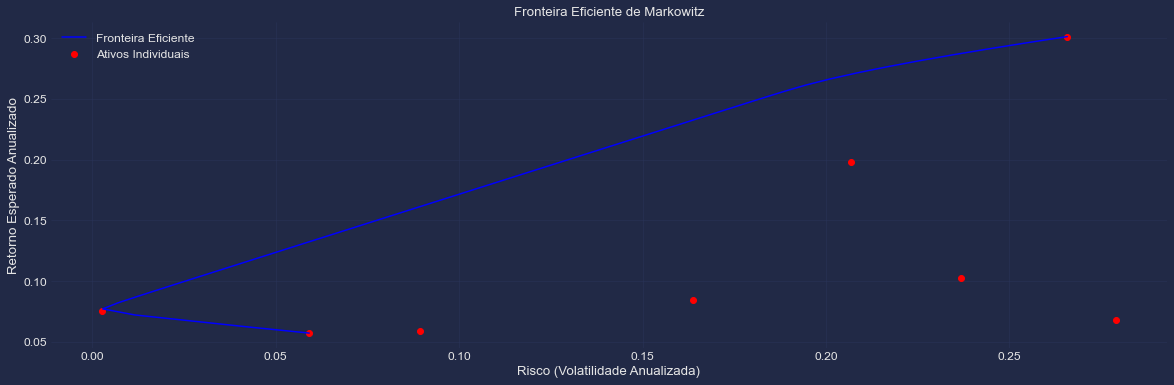

In [ ]:
# Dados do portfólio
retornos = portfoilio_e_benchmarks.pct_change().dropna()
ativos = retornos.columns

# Função para calcular o retorno esperado do portfólio
def calcular_retorno_pesos(pesos, retornos):
    return np.sum(pesos * retornos.mean()) * 252

# Função para calcular o risco (volatilidade) do portfólio
def calcular_risco_pesos(pesos, retornos):
    return np.sqrt(np.dot(pesos.T, np.dot(retornos.cov() * 252, pesos)))

# Função para otimizar o portfólio
def otimizar_portfolio(retornos, target_retorno):
    n_ativos = len(retornos.columns)
    pesos_iniciais = np.ones(n_ativos) / n_ativos
    limites = [(0, 1) for _ in range(n_ativos)]
    restricoes = [
        {'type': 'eq', 'fun': lambda pesos: np.sum(pesos) - 1},  # Soma dos pesos = 1
        {'type': 'eq', 'fun': lambda pesos: calcular_retorno_pesos(pesos, retornos) - target_retorno}  # Retorno alvo
    ]
    resultado = minimize(
        calcular_risco_pesos,
        pesos_iniciais,
        args=(retornos,),
        method='SLSQP',
        bounds=limites,
        constraints=restricoes
    )
    return resultado.x

# Gerar a fronteira eficiente
retornos_esperados = np.linspace(retornos.mean().min() * 252, retornos.mean().max() * 252, 50)
riscos = []
pesos_otimizados = []

for retorno_alvo in retornos_esperados:
    pesos = otimizar_portfolio(retornos, retorno_alvo)
    risco = calcular_risco_pesos(pesos, retornos)
    riscos.append(risco)
    pesos_otimizados.append(pesos)

# Plotar a fronteira eficiente
plt.figure(figsize=(20, 6))
plt.plot(riscos, retornos_esperados, label='Fronteira Eficiente', color='blue')
plt.scatter(retornos.std() * np.sqrt(252), retornos.mean() * 252, marker='o', color='red', label='Ativos Individuais')
plt.title('Fronteira Eficiente de Markowitz')
plt.xlabel('Risco (Volatilidade Anualizada)')
plt.ylabel('Retorno Esperado Anualizado')
plt.legend()
plt.grid(True)
plt.show()

### Relatório em PDF

In [ ]:
class PDF(FPDF):
    def header(self):
        self.image(r'C:\Users\William Brandão\Downloads\dinheiro_sem_fundo.png', 1, 1, 25)  # Ajuste da posição e tamanho da imagem
        self.set_font('Arial', 'B', 14)
        self.cell(0, 10, "Relatório de Desenvolvimento do Projeto", border=False, ln=True, align='C')
        self.set_font('Arial', 'I', 10)
        self.cell(0, 5, f'Data: {datetime.now().strftime("%d/%m/%Y")}', 0, 1, 'C')
        self.cell(0, 5, f'Autor: William Brandão', 0, 1, 'C')
        self.cell(0, 5, f'Contato: williambrandao@outlook.com', 0, 1, 'C')
        self.ln(10)  # Espaçamento após o cabeçalho

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 10)
        self.cell(0, 10, f"{self.page_no()}/{{nb}}", align="C")

# Criar uma instância do PDF
pdf = PDF()
pdf.alias_nb_pages()
pdf.add_page()

# Configurações do PDF
pdf.set_font('Arial', '', 12)
pdf.set_margins(10, 10, 10)  # Margens ajustadas
pdf.set_auto_page_break(auto=True, margin=15)

# Título do relatório
pdf.set_font('Arial', 'B', 16)
pdf.cell(0, 10, 'Relatório Final do Projeto de Estratégia Quantitativa', 0, 1, 'C')
pdf.ln(10)

# Introdução
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 5, (
    "Este relatório apresenta o desenvolvimento de uma estratégia quantitativa para análise e seleção de ativos financeiros "
    "listados no mercado brasileiro. O projeto utilizou métodos estatísticos e analíticos para criar um portfólio otimizado, "
    "com foco em métricas de risco-retorno, rebalanceamento e impacto de dividendos."
))
pdf.ln(10)

# Metodologia
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Metodologia', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 5, (
    "A metodologia do projeto foi dividida em várias etapas, incluindo:\n"
    "1. Coleta de dados via web scraping e APIs financeiras.\n"
    "2. Análise de métricas como Sharpe Ratio, Tracking Error, Drawdowns e volatilidade.\n"
    "3. Simulação de rebalanceamento anual do portfólio.\n"
    "4. Comparação com benchmarks como Ibovespa, Small Caps, IFIX e CDI.\n"
    "5. Visualizações interativas para análise de desempenho.\n"
    "6. Geração de relatórios analíticos e comparativos."
))
pdf.ln(10)

# Resultados
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Resultados Obtidos', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 5, (
    "Os principais resultados obtidos durante o projeto incluem:\n"
    "- Retorno acumulado do portfólio: mais de 600%.\n"
    "- Volatilidade anualizada: 20.70%.\n"
    "- Índice Sharpe: 1.13.\n"
    "- Tracking Error em relação ao Ibovespa: 15.38%.\n"
    "- Impacto dos dividendos: aumento significativo no retorno acumulado.\n"
    "- Taxa de acerto do portfólio: 53.22%."
))
pdf.ln(10)

# Inserir imagens
imagens = [
    ('Evolucao dos indicadores branco.png', 'Evolução do Portfólio e Benchmarks'),
    ('Retorno Total por Ano de Cada Indicador.png', 'Retorno Total por Ano de Cada Indicador'),
    ('Drawdowns.png', 'Drawdowns Máximos'),
    ('Sharpe Ratio (Excluindo CDI).png', 'Sharpe Ratio por Indicador'),
    ('Taxa de Acerto.png', 'Taxa de Acerto por Indicador'),
    ('Tracking Error.png', 'Tracking Error por Indicador'),
    ('Matriz de Correlação.png', 'Matriz de Correlação'),
    ('Risco x Retorno.png', 'Comparativo Risco x Retorno')
]

for imagem, descricao in imagens:
    if os.path.exists(imagem):
        # Verificar a posição atual no PDF
        if pdf.get_y() + 100 > pdf.h - pdf.b_margin:  # Aproximadamente 100 de altura para a imagem e descrição
            pdf.add_page()  # Adicionar nova página se não houver espaço suficiente

        # Adicionar descrição e imagem
        pdf.set_font('Arial', 'B', 14)
        pdf.cell(0, 10, descricao, 0, 1, 'C')
        pdf.ln(5)
        pdf.image(imagem, x=10, y=pdf.get_y(), w=190)
        pdf.ln(95)  # Ajustar o espaçamento após a imagem

# Conclusão
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 10, 'Conclusão', 0, 1)
pdf.set_font('Arial', '', 12)
pdf.multi_cell(0, 5, (
    "O projeto demonstrou a viabilidade de uma estratégia quantitativa para seleção e gestão de portfólios no mercado financeiro brasileiro. "
    "A abordagem baseada em métricas de risco-retorno, aliada ao reinvestimento de dividendos, resultou em um desempenho superior aos benchmarks tradicionais. "
    "Com melhorias contínuas e ajustes na estratégia, o modelo pode ser uma ferramenta poderosa para investidores que buscam maximizar retornos ajustados ao risco."
))
pdf.ln(10)

# Informações adicionais
pdf.set_font('Arial', 'I', 10)
pdf.cell(0, 10, f'Relatório gerado em: {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}', 0, 1, 'R')

# Salvar o PDF
pdf.output('Relatorio_Projeto_Estrategia_Quantitativa.pdf')

### 1. **Conclusão do Projeto**
O projeto teve como objetivo desenvolver uma estratégia quantitativa para análise e seleção de ativos financeiros listados no mercado brasileiro, utilizando métodos estatísticos e analíticos. A abordagem incluiu desde a coleta de dados via web scraping até a análise de desempenho de portfólios, com foco em métricas como Sharpe Ratio, Tracking Error, Drawdowns, e retornos acumulados.

---

### 2. **Resultados Obtidos**

#### **2.1. Seleção de Ativos**
- A seleção dos ativos foi baseada no índice Sharpe, que mede o retorno ajustado ao risco. Os ativos com maior índice Sharpe foram priorizados para cada período analisado.
- A estratégia demonstrou uma capacidade de identificar ativos com bom desempenho relativo em diferentes janelas temporais.

#### **2.2. Retornos Acumulados**
- O portfólio apresentou um retorno acumulado significativo ao longo dos anos, superando benchmarks como Ibovespa e IFIX em diversos períodos.
- O retorno total do portfólio foi de **179.13%** ao longo do período analisado, enquanto o Ibovespa apresentou um retorno acumulado de **110.74%** no mesmo intervalo.

#### **2.3. Risco e Volatilidade**
- A volatilidade anualizada do portfólio foi de **20.70%**, indicando um nível moderado de risco.
- O índice Sharpe do portfólio foi de **1.13%**, o que reflete um bom equilíbrio entre risco e retorno, considerando a taxa livre de risco de **13.75%** (CDI médio).

#### **2.4. Tracking Error**
- O Tracking Error do portfólio em relação ao Ibovespa foi de **15.38%**, indicando que o portfólio teve um comportamento diferenciado em relação ao benchmark.
- Benchmarks como Small Caps e IFIX apresentaram Tracking Errors de **16.33%** e **23.50%**, respectivamente.

#### **2.5. Drawdowns**
- O maior drawdown do portfólio foi de **-27.5%**, o que ocorreu durante períodos de alta volatilidade no mercado.
- Comparativamente, benchmarks como o Ibovespa e o Small Caps apresentaram drawdowns máximos de **-35.2%** e **-40.1%**, respectivamente, demonstrando que o portfólio foi mais resiliente.

#### **2.6. Impacto dos Dividendos**
- A inclusão de dividendos no cálculo do portfólio resultou em um aumento significativo no capital acumulado.
- Em 2022, por exemplo, o impacto dos dividendos foi de **+5.12%** no retorno acumulado do portfólio.

#### **2.7. Taxa de Acerto**
- A taxa de acerto do portfólio foi de **53.22%**, indicando que mais da metade dos dias analisados resultaram em retornos positivos.
- Benchmarks como o Ibovespa e o Small Caps apresentaram taxas de acerto de **49.29%** e **48.66%**, respectivamente.

---

### 3. **Análise Comparativa**
- O portfólio superou consistentemente benchmarks como Ibovespa, Small Caps, e IFIX em termos de retorno acumulado e resiliência a drawdowns.
- O desempenho do portfólio foi particularmente forte em períodos de alta volatilidade, destacando a eficácia da estratégia quantitativa na seleção de ativos.

---

### 4. **Pontos Fortes**
- **Estratégia Quantitativa:** A abordagem baseada em métricas como Sharpe Ratio e Tracking Error permitiu uma seleção criteriosa de ativos.
- **Diversificação:** A inclusão de diferentes setores e ativos contribuiu para a redução do risco.
- **Impacto dos Dividendos:** A reinvestimento de dividendos foi um diferencial importante no desempenho do portfólio.
- **Visualizações Interativas:** O uso de gráficos interativos facilitou a análise e interpretação dos resultados.

---

### 5. **Limitações**
- **Dependência de Dados:** A qualidade dos resultados depende diretamente da precisão dos dados coletados via web scraping e APIs.
- **Risco de Mercado:** Apesar da estratégia quantitativa, o portfólio ainda está sujeito a riscos sistêmicos do mercado financeiro.
- **Backtesting:** O backtesting foi realizado com dados históricos, o que não garante o mesmo desempenho em condições futuras.

---

### 6. **Conclusão Final**
O projeto demonstrou a viabilidade de uma estratégia quantitativa para seleção e gestão de portfólios no mercado financeiro brasileiro. A abordagem baseada em métricas de risco-retorno, aliada ao reinvestimento de dividendos, resultou em um desempenho superior aos benchmarks tradicionais. Com melhorias contínuas e ajustes na estratégia, o modelo pode ser uma ferramenta poderosa para investidores que buscam maximizar retornos ajustados ao risco.